In [1]:
%matplotlib inline
from datetime import datetime, timedelta

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.colorbar as mcbar

import pandas as pd
import numpy as np
import astropy.units as u
import astropy.constants as const

from heliopy.data import helios

import helpers
from plot_helpers import *

matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['figure.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12

figwidth = 8

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
probe = '1'
starttime = datetime(1975, 3, 13)
endtime = datetime(1975, 3, 27)

# Load alphas
alphas = helpers.load_alphafit(probe, starttime, endtime)
# Load new corefit data
protons = helios.corefit(probe, starttime, endtime).data
# Load electrons
electrons = helpers.load_electrons('1', starttime, endtime)

# Put data on the same timestamps as the alpha data
protons = protons.reindex(alphas.index)

Calculate derived proton values
---

In [3]:
protons = helpers.calculate_derived_proton(protons)
protons['n_mom'] = alphas['np_beam'] + protons['n_p']
protons['beam_frac'] = alphas['np_beam'] / protons['n_mom']

New keys:
 Index(['B instrument', 'Bx', 'By', 'Bz', 'sigma B', 'Ion instrument', 'Status',
       'Tp_par', 'Tp_perp', 'carrot', 'r_sun', 'clat', 'clong',
       'earth_he_angle', 'n_p', 'vp_x', 'vp_y', 'vp_z', 'vth_p_par',
       'vth_p_perp', '|B|', '|v|', 'Tp_tot', 'p_mag', 'p_th_par', 'p_th_tot',
       'Beta', 'Beta_tot', 'Tani', 'n_p_norm', 'mass_flux', 'Entropy', 'va_x',
       'va_y', 'va_z', '|va|'],
      dtype='object')


Calculate cross helicities
---

In [4]:
vbs = protons[['vp_x', 'vp_y', 'vp_z', 'va_x', 'va_y', 'va_z']].dropna()
vbs['Probe'] = '1'
vbs = vbs.set_index('Probe', append=True)

T = '20T'
# Calculate correlations
out = helpers.apply_downsampled_function(vbs, helpers.correl, T, 10)
sigma_c = out[0]
sigma_c.index = sigma_c.index.droplevel(level=1)

Calculate various alpha particle parameters
---

In [5]:
alphas[['Bx', 'By', 'Bz', '|B|']] = protons[['Bx', 'By', 'Bz', '|B|']]
alphas['Beta_par'] = alphas['Ta_par'] * const.k_B.value * alphas['n_a'] * 1e6 / (alphas['|B|']**2 * 1e-18 / (2 * const.mu0))
alphas['Tani'] = alphas['Ta_perp'] / alphas['Ta_par']
alphas['nanp'] = alphas['n_a'] * alphas['va_x'] / (protons['n_p'] * protons['vp_x'])
# Drift speed
for comp in ['x', 'y', 'z']:
    alphas['vd_' + comp] = alphas['va_' + comp] - protons['vp_' + comp]
alphas['|vd|'] = np.linalg.norm(alphas[['vd_x', 'vd_y', 'vd_z']].values, axis=1)
Bhat = alphas[['Bx', 'By', 'Bz']].values.T / alphas['|B|'].values
vd = alphas[['vd_x', 'vd_y', 'vd_z']].values
alphas['vd_norm'] = np.einsum('ij,ji->i', vd, Bhat) / protons['|va|']
alphas['vd/va'] = alphas['|vd|'] / protons['|va|']

# Correct proton Alfvén speed
for comp in ['x', 'y', 'z']:
    protons['va_' + comp] = protons['va_' + comp] * np.sqrt(1 / (1 + 4 * alphas['nanp']))
protons['|va|'] = np.linalg.norm(protons[['va_x', 'va_y', 'va_z']].values, axis=1)
print(alphas.keys())

Index(['Status', 'Ta_par', 'Ta_par_err', 'Ta_perp', 'Ta_perp_err', 'n_a',
       'n_a_err', 'np_beam', 'va_x', 'va_x_err', 'va_y', 'va_y_err', 'va_z',
       'va_z_err', 'Bx', 'By', 'Bz', '|B|', 'Beta_par', 'Tani', 'nanp', 'vd_x',
       'vd_y', 'vd_z', '|vd|', 'vd_norm', 'vd/va'],
      dtype='object')


Downsample data to hourly resolution
----

In [6]:
period = '60T'
alphadown = alphas.resample(period).mean()
protondown = protons.resample(period).mean()
electrondown = electrons.resample(period).mean()

Create category classes
---

In [7]:
def timefilter(df, start, stop):
    return df.loc[(df.index > start) & (df.index < stop)]

class Category:
    def __init__(self, name, starttime, endtime, colour):
        self.name = name
        self.start = starttime
        self.end = endtime
        self.colour = colour
        self.cmap = {'black': 'Greys', 'C0': 'Blues', 'C3': 'Reds'}.get(colour)
    
    def proton(self, key):
        return timefilter(protons[key], self.start, self.end)
    
    def alpha(self, key):
        return timefilter(alphas[key], self.start, self.end)
    
    def electron(self, key):
        return timefilter(electrons[key], self.start, self.end)

cats = []
cats.append(Category('Fast',
                     datetime(1975, 3, 13, 12),
                     datetime(1975, 3, 16, 12),
                     'black'))
cats.append(Category('Slow Alfvénic',
                     datetime(1975, 3, 23),
                     datetime(1975, 3, 24, 14),
                     'C0'))
cats.append(Category('Slow Non-Alfvénic',
                     datetime(1975, 3, 25, 14),
                     datetime(1975, 3, 26),
                     'C3'))

In [8]:
cmap = plt.get_cmap('tab20')

ssize = 0.5
akwargs = {'color': cmap(9), 's': ssize}
pkwargs = {'color': cmap(5), 's': ssize}
adkwarsg = {'color': cmap(8)}
pdkwargs = {'color': cmap(4)}
ekwargs = {'color': cmap(5), 's': ssize}
edkwargs = {'color': cmap(4)}

def pplot(ax, var):
    ax.scatter(protons.index, protons[var], **pkwargs)
    ax.step(protondown.index, protondown[var], where='post', **pdkwargs)

def aplot(ax, var):
    ax.scatter(alphas.index, alphas[var], **akwargs)
    ax.step(alphadown.index, alphadown[var], where='post', **adkwarsg)

def eplot(ax, var):
    ax.scatter(electrons.index, electrons[var], **ekwargs)
    ax.step(electrondown.index, electrondown[var], where='post', **edkwargs)

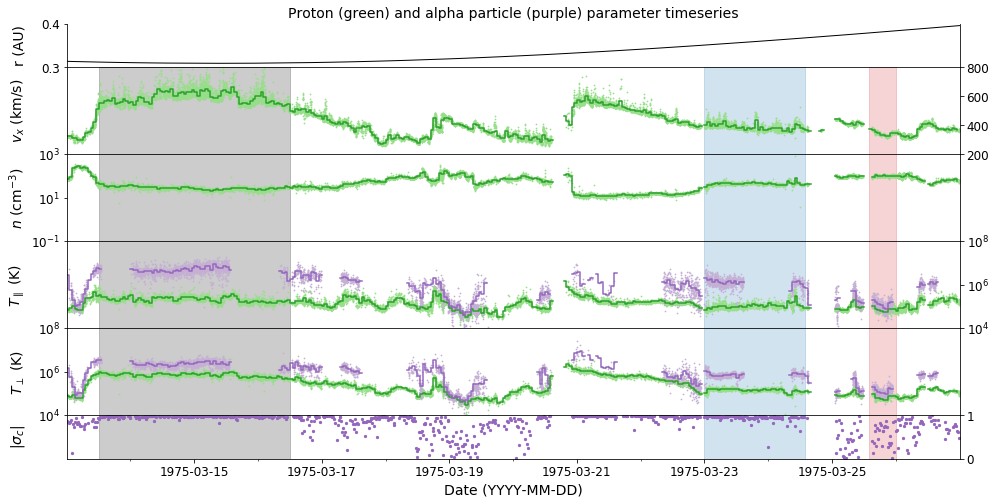

In [9]:
fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(2 * figwidth, figwidth),
                        gridspec_kw={'height_ratios': [1, 2, 2, 2, 2, 1]})
fig.subplots_adjust(hspace=0)
axs[0].set_title('Proton (green) and alpha particle (purple) parameter timeseries')

ax = axs[0]
ax.plot(protons['r_sun'], color='k', linewidth=1)
ax.set_ylim(0.3, 0.4)
ax.spines['top'].set_visible(False)

ax.set_ylabel('r (AU)')
ax = axs[1]
pplot(ax, 'vp_x')
# aplot(ax, 'va_x')

ax.set_ylim(200, 800)
ax.set_ylabel(r'$v_{x}$ (km/s)')

ax = axs[2]
pplot(ax, 'n_p')
# aplot(ax, 'n_p')
# eplot(ax, 'nc')

ax.set_yscale('log')
ax.set_ylim(1e-1, 1e3)
ax.set_ylabel(r'$n$ (cm$^{-3}$)')

ax = axs[3]
pplot(ax, 'Tp_par')
aplot(ax, 'Ta_par')
# eplot(ax, 'Tcpar')

ax.set_yscale('log')
ax.set_ylim(1e4, 1e8)
ax.set_ylabel(r'$T_{\parallel}$ (K)')

ax = axs[4]
pplot(ax, 'Tp_perp')
aplot(ax, 'Ta_perp')
# eplot(ax, 'Tc_perp')

ax.set_yscale('log')
ax.set_ylim(1e4, 1e8)
ax.set_ylabel(r'$T_{\perp}$ (K)')

ax = axs[5]
ax.scatter(sigma_c.index, sigma_c.abs(), s=5, color='C4')
ax.set_ylim(0, 1)
ax.set_ylabel(r'$\left | \sigma_{c} \right |$')

for ax in axs[1::2]:
    ax.yaxis.tick_right()
    
for ax in axs[1:]:
    for cat in cats:
        ax.axvspan(cat.start, cat.end, color=cat.colour, alpha=0.2, zorder=-1)

ax.set_xlim(alphas.index.min(), alphas.index.max())

ax = axs[-1]
ax.set_xlabel('Date (YYYY-MM-DD)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))

fig.align_labels()
fig.savefig('timeseries.pdf', bbox_inches='tight')

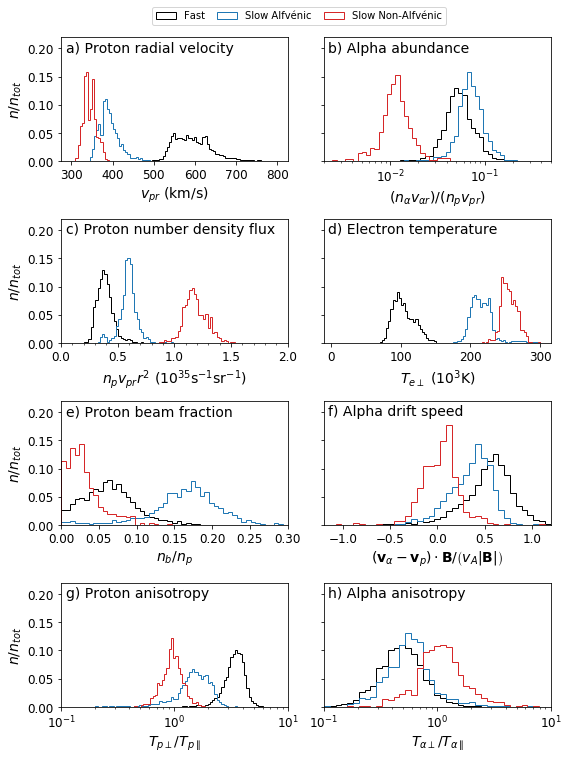

In [10]:
def panel_label(ax, label):
    ax.text(0.02, 0.88, label, transform=ax.transAxes, fontsize=14)

def normalised_hist(ax, data, color, label, logbins=False, bins=None):
    if bins is None:
        if logbins:
            _, bins = auto_logspaced_bins(data)
        else:
            bins = np.histogram_bin_edges(data, bins='auto')
    
    weights = np.ones(data.shape) / data.size
    ax.hist(data, bins=bins, weights=weights,
            histtype='step', color=color, label=label)
    
fig, axs = plt.subplots(ncols=2, nrows=4,
                        figsize=(figwidth, figwidth * 4 / 3),
                        sharey=True)


# Proton radial velocity
ax = axs[0, 0]
for cat in cats:
    vpr = cat.proton('vp_x').dropna().values
    normalised_hist(ax, vpr, cat.colour, cat.name, bins=np.linspace(300, 800, 100))
    
ax.set_xlabel(r'$v_{pr}$ (km/s)')
panel_label(ax, 'a) Proton radial velocity')
ax.legend(bbox_to_anchor=(0.4, 1.1, 1.3, 0.102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)

# Alpha abundance
ax = axs[0, 1]
for cat in cats:
    abundance = cat.alpha('nanp').dropna().values
    normalised_hist(ax, abundance, cat.colour, cat.name, bins=np.logspace(-3 + np.log10(2), -1 + np.log10(3), 50))
    
ax.set_xscale('log')
ax.set_xlabel(r'$ \left (n_{\alpha}v_{\alpha r} \right ) / \left ( n_{p}v_{pr} \right )$')
ax.set_xlim(2e-3, 5e-1)
panel_label(ax, 'b) Alpha abundance')

# Proton radial flux
ax = axs[1, 0]
for cat in cats:
    flux = (cat.proton('n_mom') *
            cat.proton('vp_x') *
            cat.proton('r_sun')**2).dropna().values * u.km * u.AU**2 / (u.s * u.cm**3)
    flux = flux.to(1 / u.s).value / 1e35
    normalised_hist(ax, flux, cat.colour, cat.name, bins=np.linspace(0, 2, 100))
    
ax.set_xlabel(r'$n_{p} v_{pr}r^{2}$ ($10^{35}$s$^{-1}$sr$^{-1}$)')
panel_label(ax, 'c) Proton number density flux')
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.1))
ax.set_xlim(0, 2)

# Electron temperatures
ax = axs[1, 1]
for cat in cats:
    te_perp = cat.electron('Tc_perp').dropna() / 1e3
    normalised_hist(ax, te_perp, cat.colour, cat.name, bins=np.linspace(5, 300, 100))

ax.set_xlabel('$T_{e\perp}$ (10$^{3}$K)')
panel_label(ax, 'd) Electron temperature')

# Proton beam fraction
ax = axs[2, 0]
for cat in cats:
    nbeam = cat.proton('beam_frac').dropna()
    normalised_hist(ax, nbeam, cat.colour, cat.name, bins=np.linspace(0, 0.3, 50))

ax.set_xlim(0, 0.3)
ax.set_xlabel('$n_{b} / n_{p}$')
panel_label(ax, 'e) Proton beam fraction')

# Alpha drift
ax = axs[2, 1]
for cat in cats:
    vdrift = cat.alpha('vd_norm').dropna()
    normalised_hist(ax, vdrift, cat.colour, cat.name, bins=np.linspace(-1.2, 1.2, 40))

ax.set_xlabel(r'$ \left ( \mathbf{v}_{\alpha} - \mathbf{v}_{p} \right ) \cdot \mathbf{B} / \left ( v_{A} \left | \mathbf{B} \right | \right )$')
ax.set_xlim(-1.2, 1.2)
panel_label(ax, 'f) Alpha drift speed')

# Proton anisotropy
ax = axs[3, 0]
for cat in cats:
    Tperp = (cat.proton('Tp_perp') / cat.proton('Tp_par')).dropna()
    normalised_hist(ax, Tperp, cat.colour, cat.name, bins=np.logspace(-1, 1, 100))

ax.set_xscale('log')
ax.set_xlim(1e-1, 1e1)
panel_label(ax, 'g) Proton anisotropy')
ax.set_xlabel(r'$T_{p\perp} / T_{p\parallel}$')

# Alpha anisotropy
ax = axs[3, 1]
for cat in cats:
    Tperp = (cat.alpha('Ta_perp') / cat.alpha('Ta_par')).dropna()
    normalised_hist(ax, Tperp, cat.colour, cat.name, bins=np.logspace(-1, 1, 40))

ax.set_xscale('log')
ax.set_xlim(1e-1, 1e1)
panel_label(ax, 'h) Alpha anisotropy')
ax.set_xlabel(r'$T_{\alpha\perp} / T_{\alpha\parallel}$')

# Axes formatting
for ax in axs[:, 0]:
    ax.set_ylabel('$n / n_{tot}$')
ax.set_ylim(0, 0.22)

fig.tight_layout()
fig.savefig('cat_stats.pdf', bbox_inches='tight')

/Users/dstansby/opt/miniconda3/envs/pub-env/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


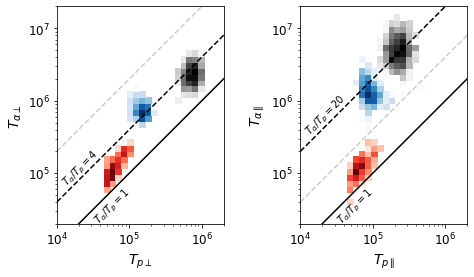

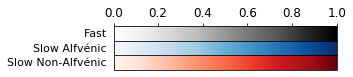

In [11]:
labels = {'perp': '\perp', 'par': '\parallel'}
fig, axs = plt.subplots(ncols=2, figsize=(figwidth, figwidth / 2))
for d, ax in zip(['perp', 'par'], axs):
    for cat in cats:
        # ax.scatter(cat.proton(f'Tp_{d}'), cat.alpha(f'Ta_{d}'), s=0.5, color=cat.colour, alpha=0.5)
        ax.hist2d(cat.proton(f'Tp_{d}'), cat.alpha(f'Ta_{d}'),
                  bins=np.logspace(4, 8, 50), cmin=5, cmap=cat.cmap,
                 norm=mcolor.LogNorm())
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_aspect('equal')
    ax.plot([1e4, 1e8], [1e4, 1e8], color='k')
    
    ax.set_xlabel(r'$T_{p' + labels[d] + '}$')
    ax.set_ylabel(r'$T_{\alpha' + labels[d] + '}$')
    ax.set_xlim(1e4, 2e6)
    ax.set_ylim(2e4, 2e7)

ax = axs[0]
ax.plot([1e4, 1e8], [4e4, 4e8], color='k', linestyle='--')
ax.plot([1e4, 1e8], [20e4, 20e8], color='k', linestyle='--', alpha=0.2)
ax.text(1.1e4, 7e4, r'$T_{\alpha} / T_{p} = 4$', rotation=45)
ax.text(3e4, 2.1e4, r'$T_{\alpha} / T_{p} = 1$', rotation=45)

ax = axs[1]
ax.plot([1e4, 1e8], [4e4, 4e8], color='k', linestyle='--', alpha=0.2)
ax.plot([1e4, 1e8], [20e4, 20e8], color='k', linestyle='--')
ax.text(1.1e4, 3.5e5, r'$T_{\alpha} / T_{p} = 20$', rotation=45)
ax.text(3e4, 2.1e4, r'$T_{\alpha} / T_{p} = 1$', rotation=45)

fig.savefig('temps.pdf', bbox_inches='tight')

fig_cbar, axs = plt.subplots(nrows=3, sharex=True, figsize=(figwidth / 2, figwidth / 10))
for ax, cmap, cat in zip(axs,
                    ['Greys', 'Blues', 'Reds'],
                    cats):
    mcbar.ColorbarBase(ax, cmap=plt.get_cmap(cmap), orientation='horizontal')
    ax.text(-0.03, 0.3, cat.name, size=11, transform=ax.transAxes, ha='right')
for ax in axs[1:]:
    ax.set_axis_off()
axs[0].xaxis.tick_top()
fig_cbar.subplots_adjust(hspace=0)
fig_cbar.savefig('temp_cbar.pdf', bbox_inches='tight')